# **Set according to environment (e.g. local, Google Colab...)**

In [7]:
project_folder = ''

# **Body**

In [8]:
from custom_libraries.miscellaneous import progress_bar
from custom_libraries.image_dataset import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt
import gc

In [9]:
weighting = 'paired'
trials = 10
classes = 26

ds_set = ['emnist']

paired_test = np.zeros((len(ds_set), trials, classes, classes))
heatmap_matrix = np.zeros((len(ds_set), classes, classes))

for k, ds in enumerate(ds_set):

    print(f"- Dataset: {ds}")

    for t1 in range(10, classes + 10):
        for t2 in range(t1 + 1, classes + 10):

            test_ds = ImageDataset(ds, 'test', data_dir=None)
            train_ds = ImageDataset(ds, 'train', data_dir=None)

            for x in [train_ds, test_ds]:
                x.filter(t1, t2, overwrite=True)
                x.shuffle()
                x.normalize()
                if x.images.shape[1:3] == (28, 28):
                    x.pad()
                x.vectorize(True)

            finished = False

            while not finished:

                try:

                    progress_bar(0, max=10, pre=f"-- Pair {t1} - {t2}:\t")
                    test_ds.shuffle()
                    train_ds.shuffle()
                    X_test, y_test = test_ds.subset(validation=False)
                    X_train, y_train, _, _ = train_ds.subset(shard=True, shard_number=trials, validation=True,
                                                             validation_size=len(X_test))

                    average_acc = 0

                    for m in range(trials):
                        lda = LinearDiscriminantAnalysis()
                        lda.fit(X_train[m], y_train[m])
                        score_test = lda.score(X_test, y_test)

                        paired_test[k, m, t1 - 10, t2 - 10] = score_test
                        average_acc = average_acc + score_test
                        progress_bar(m + 1, max=10, pre=f"-- Pair {t1} - {t2}:\t")

                    heatmap_matrix[k][t1 - 10][t2 - 10], heatmap_matrix[k][t2 - 10][
                        t1 - 10] = average_acc / trials, average_acc / trials
                    progress_bar(10, max=10, pre=f"-- Pair {t1} - {t2}:\t",
                                 post=f"\tAccuracy = {heatmap_matrix[k][t1 - 10][t2 - 10]}")
                    print()

                    finished = True

                    del X_train, y_train, X_test, y_test, train_ds, test_ds
                    gc.collect()

                except:

                    print("\nAn error occurred. Repeating the pair.")

# Salvo il risultato in un binario numpy
np.save(project_folder + 'results/confused_pairs_emnist.npy', paired_test)
np.save(project_folder + 'results/confused_pairs_emnist_matrix.npy', heatmap_matrix)


- Dataset: emnist
-- Pair 10 - 11:	[====================] 100%	Accuracy = 0.8475438596491228
-- Pair 10 - 12:	[====================] 100%	Accuracy = 0.9461620849696539
-- Pair 10 - 13:	[====================] 100%	Accuracy = 0.8875067897881588
-- Pair 10 - 14:	[====================] 100%	Accuracy = 0.8816518557239938
-- Pair 10 - 15:	[====================] 100%	Accuracy = 0.9018385291766584
-- Pair 10 - 16:	[====================] 100%	Accuracy = 0.8082173624917163
-- Pair 10 - 17:	[====================] 100%	Accuracy = 0.7244472520530639
-- Pair 10 - 18:	[====================] 100%	Accuracy = 0.932154340836013
-- Pair 10 - 19:	[====================] 100%	Accuracy = 0.878909952606635
-- Pair 10 - 20:	[====================] 100%	Accuracy = 0.767797783933518
-- Pair 10 - 21:	[====================] 100%	Accuracy = 0.9197115384615385
-- Pair 10 - 22:	[====================] 100%	Accuracy = 0.898272477424421
-- Pair 10 - 23:	[====================] 100%	Accuracy = 0.864401160381268
-- Pair 10 -

# **Analisi risultati**

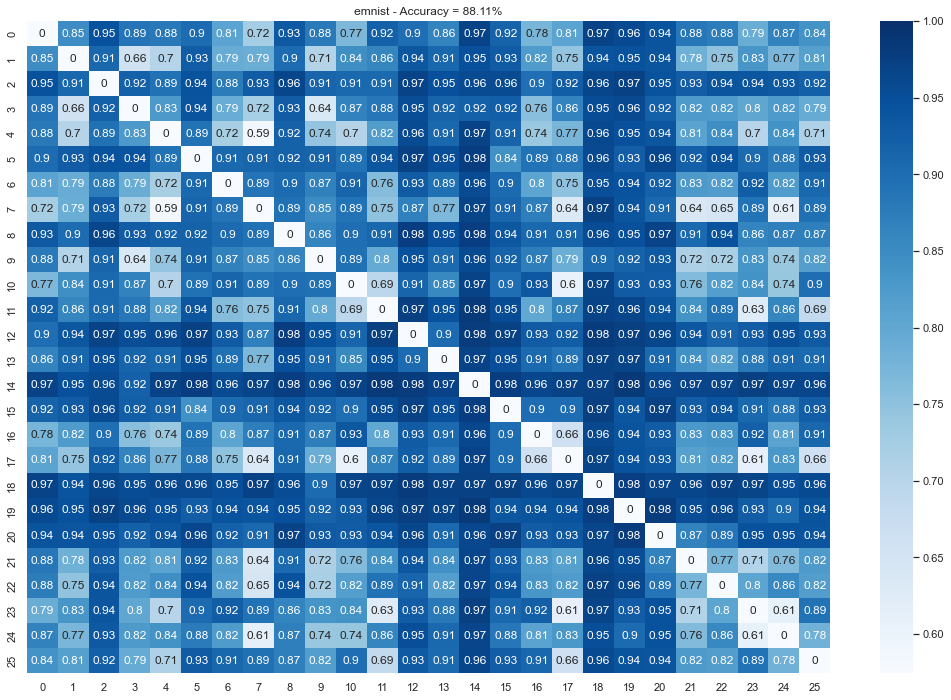

In [10]:
heatmap_matrix = np.load(project_folder + 'results/confused_pairs_emnist_matrix.npy')
ds_set = ['emnist']

for k in range(len(ds_set)):
    sns.set(rc={"figure.figsize": (18, 12)})
    heat = heatmap_matrix[k]
    min_acc = .975 * min(heat[np.nonzero(heat)])
    plt.figure()
    ax = sns.heatmap(heat, annot=True, cmap='Blues', vmin=min_acc, vmax=1)
    ax.set_title(ds_set[k] + f" - Accuracy = {round(np.mean(heat[np.nonzero(heat)]) * 100, 2)}%")